# Homework 1: Text Mining
## Part 2: Text analysis

Group Members: Matias Borrel, Pol Garcia, Marvin Ernst

#### Importing relevant Libraries:

In [627]:
import os
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
import unidecode
from textblob import TextBlob  # For sentiment analysis - we have seen this in our statistics course already, when we had to analyze hotel reviews for homework 3 last term.

[nltk_data] Downloading package stopwords to /Users/Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Define file paths:

In [628]:
files = {
    "Barcelona": {
        "During": "./Original_data/hotels_barcelona_MWC.csv",
        "Post": "./Original_data/hotels_barcelona_after_MWC.csv",
    },
    "Madrid": {
        "During": "./Original_data/hotels_madrid_MWC.csv",
        "Post": "./Original_data/hotels_madrid_after_MWC.csv",
    },
}

#### Load Data:

In [629]:
dataframes = {city: {key: pd.read_csv(path) for key, path in city_files.items()} for city, city_files in files.items()}

#### Inspect the data frames:

Print column names for each dataframe:

In [630]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"{city} - {period}:")
        print(df.columns)
        print("\n")

Barcelona - During:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'stars', 'center',
       'num_coments', 'Description'],
      dtype='object')


Barcelona - Post:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'stars', 'center',
       'num_coments', 'Description'],
      dtype='object')


Madrid - During:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'stars', 'center',
       'num_coments', 'Description'],
      dtype='object')


Madrid - Post:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'stars', 'center',
       'num_coments', 'Description'],
      dtype='object')




In [631]:
for city, periods in dataframes.items():
    print(f"{city} - During dataset shape: {periods['During'].shape}")
    print(f"{city} - Post dataset shape: {periods['Post'].shape}")

Barcelona - During dataset shape: (796, 8)
Barcelona - Post dataset shape: (999, 8)
Madrid - During dataset shape: (649, 8)
Madrid - Post dataset shape: (976, 8)


#### Preparing the Dataframes

We want that during and post treatment we have the same units (here "hotels") in each of the groups (here "city"). 

Checking how many missings we have:

In [632]:
for city, periods in dataframes.items():
    print(f"--- {city} ---")
    for period, df in periods.items():
        print(f"{period}:")
        print(df.isnull().sum())  # Count missing values per column
        print("\n")

--- Barcelona ---
During:
Name             0
Price            0
Rating          48
Detail Link      0
stars          109
center           0
num_coments     57
Description      0
dtype: int64


Post:
Name            0
Price           0
Rating          9
Detail Link     0
stars          89
center          0
num_coments    11
Description     0
dtype: int64


--- Madrid ---
During:
Name             0
Price            0
Rating          19
Detail Link      0
stars          125
center         649
num_coments     29
Description      0
dtype: int64


Post:
Name             0
Price            0
Rating          43
Detail Link      0
stars          173
center         976
num_coments     58
Description      0
dtype: int64




The distance to city center is not observed for Madrid, thus, we will drop that column. Further, we will focus on hotels, in this analysis. For this reason we only include observations with stars.

Checking for duplicate names:

In [633]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Check for duplicates in the 'Name' column
        duplicate_count = df['Name'].duplicated().sum()  # Count duplicates
        total_names = df['Name'].shape[0]  # Total number of rows
        print(f"{city} - {period}:")
        print(f"Total Names: {total_names}, Duplicates: {duplicate_count}")
        
        if duplicate_count > 0:
            # Display duplicate rows
            duplicates = df[df['Name'].duplicated(keep=False)]
            print("Duplicate Names:")
            print(duplicates[['Name']])
        print("\n")

Barcelona - During:
Total Names: 796, Duplicates: 1
Duplicate Names:
                                 Name
742  Canela Homes BARCELONA DIPUTACIÓ
743  Canela Homes BARCELONA DIPUTACIÓ


Barcelona - Post:
Total Names: 999, Duplicates: 2
Duplicate Names:
                  Name
669  Central Apartment
684   Gracia Apartment
708   Gracia Apartment
768  Central Apartment


Madrid - During:
Total Names: 649, Duplicates: 0


Madrid - Post:
Total Names: 976, Duplicates: 1
Duplicate Names:
               Name
171  Cruz Apartment
449  Cruz Apartment




Filter Out Rows with Empty Names, or missing values for any of the columns:

In [634]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Drop rows with missing values in any column
        df = df.drop('center', axis=1, errors='ignore')
        dataframes[city][period] = df.dropna(how='any')

##### Retain Only Names Present in Both During and Post:

In [635]:
for city, periods in dataframes.items():
    # Get the intersection of names in During and Post datasets
    common_names = set(periods['During']['Name']).intersection(set(periods['Post']['Name']))
    
    # Filter rows in both During and Post to only include these common names
    dataframes[city]['During'] = periods['During'][periods['During']['Name'].isin(common_names)]
    dataframes[city]['Post'] = periods['Post'][periods['Post']['Name'].isin(common_names)]

Verify Results:

In [636]:
for city, periods in dataframes.items():
    print(f"{city} - During dataset shape: {periods['During'].shape}")
    print(f"{city} - Post dataset shape: {periods['Post'].shape}")
    print(f"{city} - Common Names: {len(set(periods['During']['Name']).intersection(set(periods['Post']['Name'])))}")

Barcelona - During dataset shape: (339, 7)
Barcelona - Post dataset shape: (339, 7)
Barcelona - Common Names: 339
Madrid - During dataset shape: (402, 7)
Madrid - Post dataset shape: (402, 7)
Madrid - Common Names: 402


Check for duplicates after filtering out observations:

In [637]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Check for duplicates in the 'Name' column
        duplicate_count = df['Name'].duplicated().sum()  # Count duplicates
        total_names = df['Name'].shape[0]  # Total number of rows
        print(f"{city} - {period}:")
        print(f"Total Names: {total_names}, Duplicates: {duplicate_count}")
        
        if duplicate_count > 0:
            # Display duplicate rows
            duplicates = df[df['Name'].duplicated(keep=False)]
            print("Duplicate Names:")
            print(duplicates[['Name']])
        print("\n")

Barcelona - During:
Total Names: 339, Duplicates: 0


Barcelona - Post:
Total Names: 339, Duplicates: 0


Madrid - During:
Total Names: 402, Duplicates: 0


Madrid - Post:
Total Names: 402, Duplicates: 0




Since we do not have any dublicates, it may seem like that names uniquely identify a specific "offer" on booking, however, there are cases where accomodations are offered on booking that have the same name because they may be in the sam e apartment complex or belong to the same "group" but are not the same accomodations as we have seen above. One easy way for us to filter these out is by further matching the descriptions. Since we scrapped both periods at the same time, i.e. the information was obtained at the same time, changes in the description would not be due to changes that the agents made, but due to the fact that two observations may have the same name, but are not actually the same accomodation. (This we will do after putting all observatiosn in one dataframe to visualize the changes.)

#### Convert the Price to numeric:

In [638]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Remove all non-numeric characters (e.g., € and spaces) and dots (thousands separators)
        df['Price'] = (
            df['Price']
            .astype(str)  # Ensure the column is treated as strings
            .str.replace(r'[^\d]', '', regex=True)  # Remove non-numeric characters
            .astype(int)  # Convert cleaned strings to integers
        )

Verify the changes:

In [639]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"--- {city} - {period} ---")
        print(df[['Name', 'Price']].head())  # Show the 'Name' and cleaned 'Price' columns
        print("\n")

--- Barcelona - During ---
                                     Name  Price
0                        Isabella's House   2142
1                         Sonder Casa Luz   4870
4  Axel TWO Barcelona 4 Sup - Adults Only   2149
6                           Acta Voraport   1540
7                         Tembo Barcelona   2840


--- Barcelona - Post ---
                            Name  Price
0        chic&basic Habana Hoose   1075
3                   Hotel Market    830
6  Travelodge Barcelona Poblenou    656
7                      Exe Mitre    744
8                  Hotel Condado    698


--- Madrid - During ---
                                           Name  Price
0                               Room Mate Oscar   1069
1  El Autor Hotel, Madrid, Autograph Collection   2409
2                                Hostal Mendoza    584
4           Amor de Dios 17 Boutique Apartments    752
5              Apartamento Plaza Mayor centrico    534


--- Madrid - Post ---
                       Name  Pri

##### Deleting the Link column:

In [640]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Drop the 'Detail Link' column if it exists
        if 'Detail Link' in df.columns:
            df.drop(columns=['Detail Link'], inplace=True)

#### Convert the Ranking to numeric:

(num_coments and star are already type float.)

In [641]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        if 'Rating' in df.columns:
            # Extract numeric values, replace commas with dots, and convert to float
            df['Rating'] = (
                df['Rating']
                .astype(str)  # Ensure all values are strings
                .str.extract(r'(\d+,\d+)')  # Extract only the first valid number
                .replace(',', '.', regex=True)  # Replace comma with dot
                .astype(float)  # Convert to float
            )

Verify the changes:

In [642]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"--- {city} - {period} ---")
        print(df[['Name', 'Rating']].head())  
        print("\n")

--- Barcelona - During ---
                                     Name  Rating
0                        Isabella's House    8.58
1                         Sonder Casa Luz    8.48
4  Axel TWO Barcelona 4 Sup - Adults Only    8.38
6                           Acta Voraport    8.88
7                         Tembo Barcelona    8.88


--- Barcelona - Post ---
                            Name  Rating
0        chic&basic Habana Hoose    8.58
3                   Hotel Market    7.67
6  Travelodge Barcelona Poblenou    7.37
7                      Exe Mitre    8.38
8                  Hotel Condado    8.58


--- Madrid - During ---
                                           Name  Rating
0                               Room Mate Oscar    8.78
1  El Autor Hotel, Madrid, Autograph Collection    9.59
2                                Hostal Mendoza    7.97
4           Amor de Dios 17 Boutique Apartments    7.87
5              Apartamento Plaza Mayor centrico    6.86


--- Madrid - Post ---
              

#### Summarize and Compare:

In [643]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        avg_price = round(df['Price'].mean(), 2)  # Round average price to 2 decimal places
        avg_score = round(df['Rating'].mean(), 2)  # Round average score to 2 decimal places
        print(f"{city} - {period}: Avg Price = {avg_price}, Avg Score = {avg_score}")

Barcelona - During: Avg Price = 2701.09, Avg Score = 8.36
Barcelona - Post: Avg Price = 1179.2, Avg Score = 8.37
Madrid - During: Avg Price = 1228.76, Avg Score = 8.0
Madrid - Post: Avg Price = 1341.54, Avg Score = 8.0


We see a small difference here between the average score for Barcelona, this shows us that likely what expected that just matching the names may not be sufficient. Therefore we look in the following first whether descriptions are the same.

## (a) Preprocess the Text 

##### Looking at the first few descriptions:

In [644]:
pd.set_option('display.max_colwidth', None) # to see the full descriptions

for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"--- {city} - {period} ---")
        print(df[['Name', 'Description']].head())  
        print("\n")

--- Barcelona - During ---
                                     Name  \
0                        Isabella's House   
1                         Sonder Casa Luz   
4  Axel TWO Barcelona 4 Sup - Adults Only   
6                           Acta Voraport   
7                         Tembo Barcelona   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

##### Checking if descriptions match for both observation times:

In [645]:
for city, periods in dataframes.items():
    # Merge the During and Post dataframes on 'Name'
    merged_df = periods['During'].merge(periods['Post'], on='Name', suffixes=('_During', '_Post'))
    
    mismatched = merged_df[merged_df['Description_During'] != merged_df['Description_Post']]
    
    print(f"--- {city}: Description Differences ---")
    if mismatched.empty:
        print("All descriptions match!")
    else:
        print(mismatched[['Name', 'Description_During', 'Description_Post']])
    print("\n")

--- Barcelona: Description Differences ---
                Name  \
325  Sagrada Familia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Description_During  \
325  Sagrada Familia se encuentra en el barrio de Eixample, en Barcelona, cerca de Sagrada Familia. Dispone de terraza, wifi gratis y lavadora. Este apartamento está a 2,9 km de Platja de la Nova Icària y a 19 min a pie de Estación de metro Passeig de Gràcia.\n\nEste apartamento con aire acondicionado se compone de 1 dormitori

From the descriptions that differ we can see that we actually have two different rooms for Barcelona with the same name. 

#### Generate a dataframe for all four observations:

In [646]:
final_data = []

for city, periods in dataframes.items():
    merged_df = periods['During'].merge(periods['Post'], on='Name', suffixes=('_During', '_Post'))

    # Remove rows where descriptions do not match
    merged_df = merged_df[merged_df['Description_During'] == merged_df['Description_Post']]
    
    merged_df['Barcelona'] = 1 if city == "Barcelona" else 0

    # During_Treatment = 1 for "During" period (event happening), 0 for "Post" period (no treatment)
    selected_columns_during = merged_df[['Name', 'Barcelona', 'Price_During', 'Rating_During','stars_During','num_coments_During','Description_During']].copy()
    selected_columns_during['During_Treatment'] = 1  

    selected_columns_post = merged_df[['Name', 'Barcelona', 'Price_Post', 'Rating_During','stars_During','num_coments_During', 'Description_During']].copy()
    selected_columns_post['During_Treatment'] = 0  

    selected_columns_during.rename(columns={'Price_During': 'Price', 'Rating_During': 'Rating','stars_During':'stars', 'num_coments_During':'num_coments','Description_During': 'Description'}, inplace=True)
    selected_columns_post.rename(columns={'Price_Post': 'Price', 'Rating_During': 'Rating', 'stars_During':'stars', 'num_coments_During':'num_coments','Description_During': 'Description'}, inplace=True)

    final_data.append(selected_columns_during)
    final_data.append(selected_columns_post)

final_df = pd.concat(final_data, ignore_index=True)

In [647]:
final_df.shape

(1480, 8)

This shows us that exactly two observations have been removed (before we two accomodatiosn with the same name but different description, now not anymore).

In [648]:
print(final_df.head())

                                     Name  Barcelona  Price  Rating  stars  \
0                        Isabella's House          1   2142    8.58    4.0   
1                         Sonder Casa Luz          1   4870    8.48    4.0   
2  Axel TWO Barcelona 4 Sup - Adults Only          1   2149    8.38    4.0   
3                           Acta Voraport          1   1540    8.88    3.0   
4                         Tembo Barcelona          1   2840    8.88    4.0   

   num_coments  \
0        1.390   
1        2.889   
2        2.742   
3       13.850   
4        2.697   

                                                                                                                                                                                                                                                                                                                                                                                                                                      

#### Normalize and Remove Special Characters:

In [649]:
final_df['Description'] = final_df['Description'].str.replace(r'[√©√±]', '', regex=True)

#### Tokenize, Remove Stop Words, and Stem:

We use Spanish Snowball Stemmer for better accuracy:

In [650]:
stemmer = SnowballStemmer("spanish")

Spanish stopwords and city names to remove:

In [651]:
stop_words = set(stopwords.words("spanish")) | {"barcelona", "madrid", "hotel"}

Regex pattern to detect numbers followed by distance or time units:

In [652]:
distance_pattern = re.compile(r"(\d+)\s+(km|kilometros|metros|millas|yardas|m|ft|feet|yd)", re.IGNORECASE)
time_pattern = re.compile(r"(\d+)\s+(min|mins|minuto|minutos|hora|horas)", re.IGNORECASE)

We believe lemmatization (instead of stemming) for better Spanish text processing.

In [653]:
def preprocess_text(text):
    if pd.isna(text):
        return ""  # Handle NaN values

    text = text.lower()  # Convert to lowercase

    # Preserve numbers with distance/time expressions as a single token
    text = distance_pattern.sub(lambda x: f"{x.group(1)}_{x.group(2)}", text)
    text = time_pattern.sub(lambda x: f"{x.group(1)}_{x.group(2)}", text)

    # Remove accents, punctuation, and standalone numbers (except for preserved ones)
    text = unidecode.unidecode(text)  # Remove accents (á -> a, ñ -> n)
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\b\d+\b", "", text)  # Remove standalone numbers

    # Tokenization and Stemming
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return " ".join(stemmed_tokens)

# Apply preprocessing to the dataset
final_df['Cleaned_Description'] = final_df['Description'].astype(str).apply(preprocess_text)

## (b) Create Word Clouds:

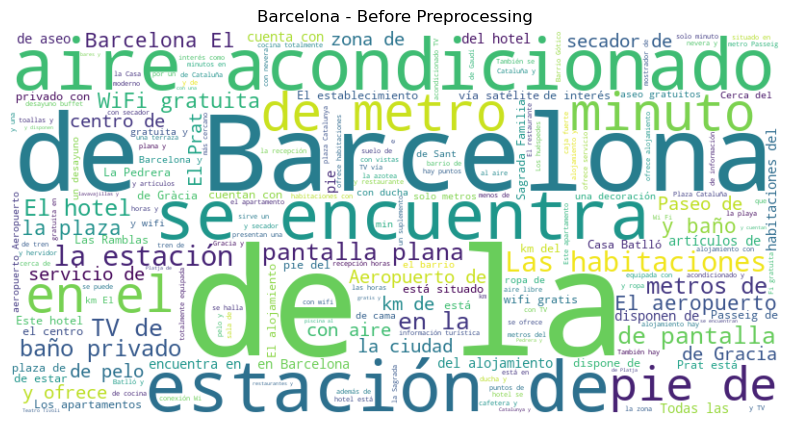

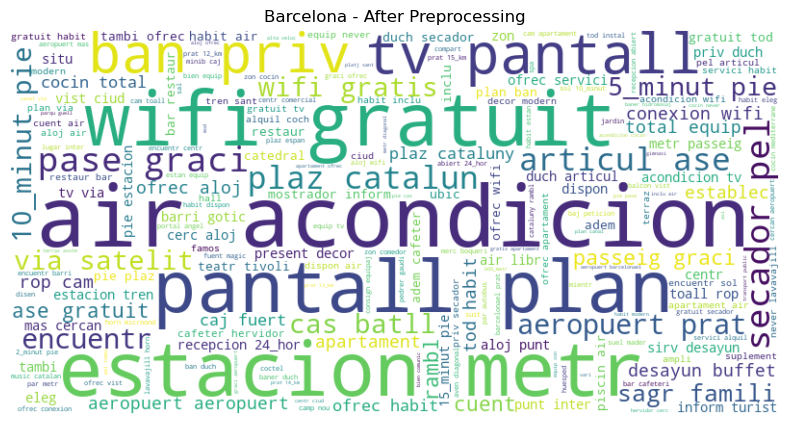

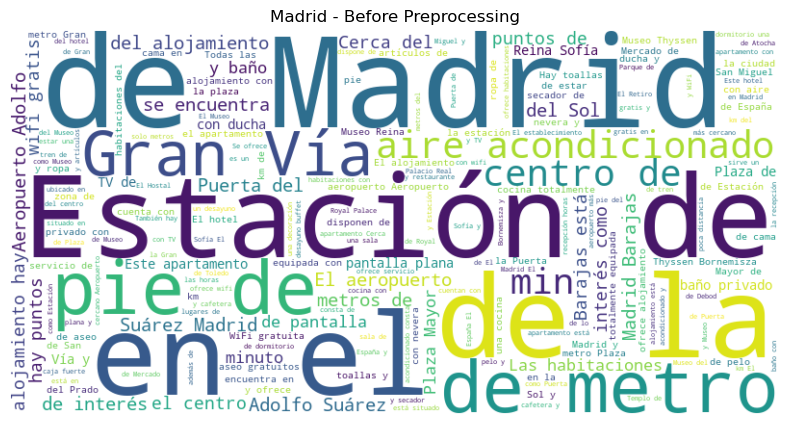

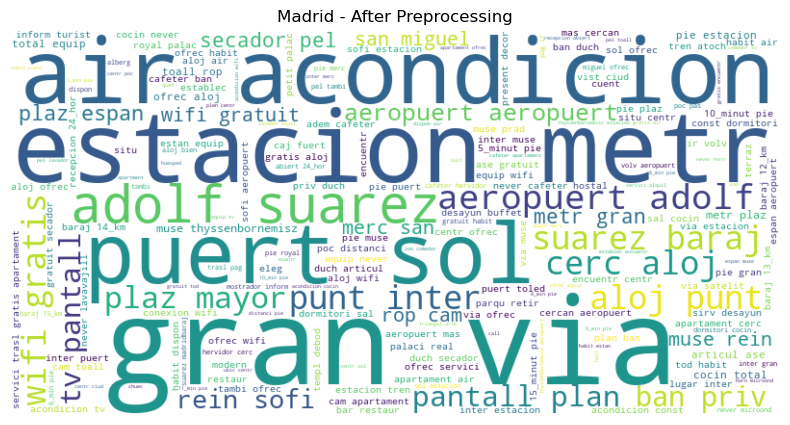

In [654]:
def generate_wordcloud(text, title, filename, show=True):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')  # Save the word cloud
    if show:
        plt.show()  # Display in output
    plt.close()  # Close to avoid duplicate plots

# Generate and save word clouds for each city before and after preprocessing
for city_label, city_name in [(1, "Barcelona"), (0, "Madrid")]:
    city_df = final_df[final_df['Barcelona'] == city_label]
    
    # Raw descriptions
    generate_wordcloud(city_df['Description'].dropna(), f"{city_name} - Before Preprocessing", f"{city_name.lower()}_before.png")

    # Cleaned descriptions
    generate_wordcloud(city_df['Cleaned_Description'].dropna(), f"{city_name} - After Preprocessing", f"{city_name.lower()}_after.png")

We can see that the words have improved a lot and now show words that seem to be more important for an analysis such as "air acondicion" or "wifi" compared to just the name of the city or "de la".

## Extracting Metadata:

In [655]:
special_words = ["centro", "playa", "aeropuerto", "wifi", "metro", "piscina"]
luxury_words = ["spa","lujoso","lujoso", "exclusivo", "premium","sofisticado","personalizado","masajes", "sauna"]

def extract_metadata(text):
    if pd.isna(text) or text.strip() == "":
        return pd.Series([0, 0, 0, 0, 0])  # Handle empty cases

    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    # Compute metadata features
    word_count = len(words)
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / max(1, word_count)  # Avoid division by zero
    sentiment_score = TextBlob(text).sentiment.polarity  # Sentiment polarity

    # Count occurrences of special words
    special_mentions = sum(text.count(word) for word in special_words)
    luxury_mentions=sum(text.count(word) for word in luxury_words)

    return pd.Series([word_count, sentence_count, avg_word_length, special_mentions, sentiment_score,luxury_mentions])

# Apply function to create metadata columns
final_df[["Word_Count", "Sentence_Count", "Avg_Word_Length", "Special_Mentions", "Sentiment_Score","Luxury_Score"]] = \
    final_df["Cleaned_Description"].apply(extract_metadata)

####  Save Cleaned Data:

In [656]:
final_df.to_csv("final_cleaned_data.csv", index=False)